<a href="https://colab.research.google.com/github/aquangnguyen1992/global_wheat_detection/blob/master/Global_Wheat_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Mount Google Drive and create the workspace***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import shutil
shutil.copy("/content/drive/My Drive/global-wheat-detection.zip", "/content/")

'/content/global-wheat-detection.zip'

In [4]:
!sudo apt-get install unzip
!unzip "global-wheat-detection.zip" 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
Archive:  global-wheat-detection.zip
  inflating: sample_submission.csv   
  inflating: test/2fd875eaa.jpg      
  inflating: test/348a992bb.jpg      
  inflating: test/51b3e36ab.jpg      
  inflating: test/51f1be19e.jpg      
  inflating: test/53f253011.jpg      
  inflating: test/796707dd7.jpg      
  inflating: test/aac893a91.jpg      
  inflating: test/cb8d261a3.jpg      
  inflating: test/cc3532ff6.jpg      
  inflating: test/f5a1f0358.jpg      
  inflating: train.csv               
  inflating: train/00333207f.jpg     
  inflating: train/005b0d8bb.jpg     
  inflating: train/006a994f7.jpg     
  inflating: train/00764ad5d.jpg     
  

# ***Setup the path and analysis the data***

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
from ast import literal_eval

In [9]:
train_images_path = "/content/train/"
train_images = os.listdir(train_images_path)

test_images_path = "/content/test/"
test_images = os.listdir(test_images_path)

ground_truth = pd.read_csv("/content/train.csv")
ground_truth.head(5)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [68]:
# Check the resolution
if len(np.unique(np.array(ground_truth['width'])))>1 or len(np.unique(np.array(ground_truth['height'])))>1:
  print("Mulitple images size for ground truth")
  
if np.any(np.array(ground_truth['bbox']) is None):
  print("No detection in some train data")
else:
  print(len(np.array(ground_truth['bbox'])), len(np.array(ground_truth['image_id'])))

# Check images format
extension = []
for each_image in train_images:
  extension.append(each_image.split(".")[-1])
if len(np.unique(np.array(extension))) > 1:
   print("Multiple extension")
   print((np.unique(np.array(extension))))
else:
   print("One image type: " + extension[0])

147793 147793
One image type: jpg


(26, 144) (150, 261)


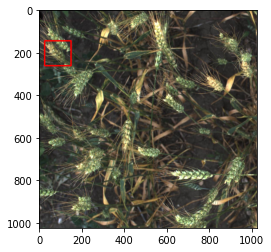

In [77]:
# Display an example
i = 4

im = cv2.imread(os.path.join(train_images_path, ground_truth['image_id'][i] + "." + extension[i]))
box = literal_eval(ground_truth['bbox'][i])
point1 = (int(box[0]), int(box[1]))
point2 = (int(box[0]+box[2]), int(box[1]+box[3]))
print(point1, point2)
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
im = cv2.rectangle(im, point1, point2, (255, 0, 0), 5)
plt.imshow(im)


In [55]:
box = 

literal_eval(ground_truth['bbox'][i])

[834.0, 222.0, 56.0, 36.0]